# Data visualization

In this notebook, we create sample visualizations of our data to show examples of the usage of data science tools to performance analysis in HPC.

## Import packages

Most of our data wrangling is done with `polars`  
We use `matplotlib` to create our plots.

In [34]:
import polars as pl
import matplotlib as mlp
import matplotlib.pyplot as plt

## Data reading

We read our data and clean up the data set

In [2]:
df = pl.read_parquet("output_80_greedylb_196761.pq", columns=["Parent", "Start", "End", "Duration", "Value"])
df = df.drop_nulls()
for col in df.iter_columns():
    col = col.str.strip_chars()
    if col.name == "Parent":
        col = col.str.replace(r"^pe", "").cast(pl.Int32)
    elif col.name != "Value":
        col = col.cast(pl.Float32)
    df = df.with_columns(col)
df = df.rename({"Value": "Chare", "Parent": "Processing Element"})

## Chare frequency chart
In this section we show a chart of the frequency of chares in this execution of the simulation.

In [3]:
frequency_df = df.group_by("Chare").agg(pl.len()).sort(by="len")

Text(0.5, 0, 'Frequency')

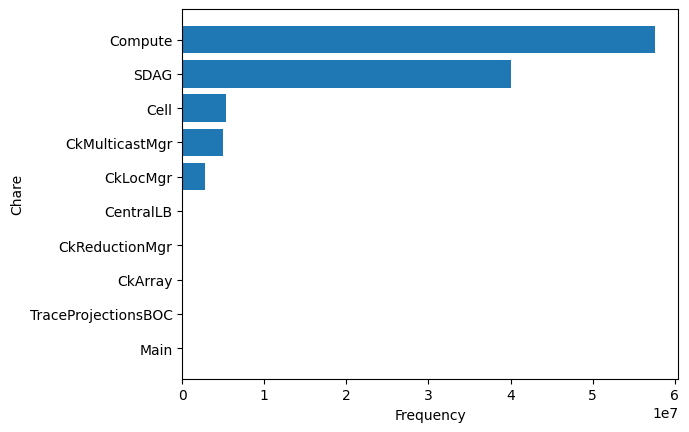

In [4]:
fig, ax = plt.subplots()
ax.barh(y=frequency_df["Chare"], width=frequency_df["len"])
ax.set_ylabel("Chare")
ax.set_xlabel("Frequency")
# ax.set_title("Frequency of Chare execution across all Processing Elements")

## Duration of each chare across all Processing Elements

In [5]:
durations_df = df.group_by("Chare").agg(pl.sum("Duration")).sort(by="Duration")

Text(0.5, 0, 'Duration (ms)')

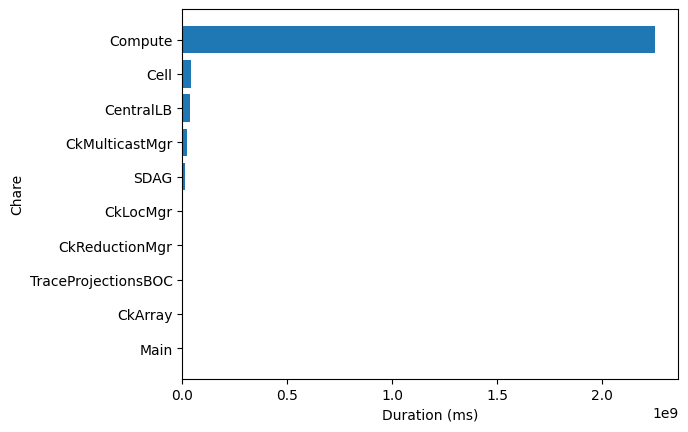

In [6]:
fig, ax = plt.subplots()
ax.barh(y=durations_df["Chare"], width=durations_df["Duration"])
ax.set_ylabel("Chare")
ax.set_xlabel("Duration (ms)")
# ax.set_title("Duration of Chare execution across all Processing Elements")

## Gantt chart

In [ ]:
df_computes = df.filter(pl.col("Chare")=="Compute")

In [ ]:
fig, ax = plt.subplots()

In [ ]:
for row in df_computes.iter_rows():
    ax.barh(
        y=row[4],
        width=row[3],
        left=row[1],
        height=0.4,
        color='skyblue',
        edgecolor='black'
    )
    # ax.text(row['Start'], pe_to_y[row['Processing Element']] + 0.1, row['Chare'], fontsize=8)


## Heatmap

In [7]:
bin_size = 1_000_000.0

binned_df = df.with_columns([
    (pl.col("Start") // bin_size).cast(pl.Int32).alias("Time Bin")
])

In [179]:
agg_df = binned_df.group_by(["Processing Element", "Time Bin"]).\
    agg(pl.sum("Duration")*0.0001).\
        sort(["Processing Element", "Time Bin"])

In [173]:
heatmap_df = agg_df.pivot(index="Processing Element", on="Time Bin", values="Duration")

In [174]:
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", ["#ffffff", "#ff0000"])

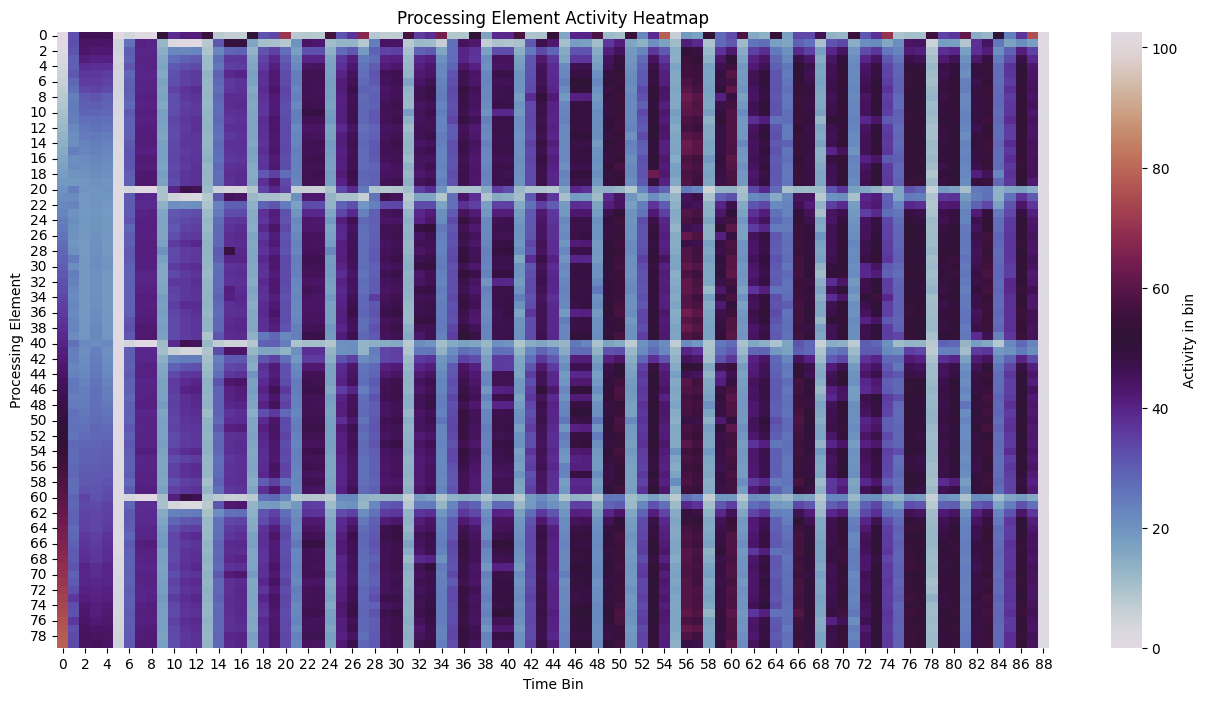

In [178]:
import seaborn as sns
fig = plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    heatmap_df,
    cmap="twilight",
    # cmap=custom_cmap,  # or "magma", "coolwarm", etc.
    cbar_kws={'label': 'Activity in bin'},
    linecolor='none'
)
ax.set_title("Processing Element Activity Heatmap")
ax.set_xlabel("Time Bin")
ax.set_ylabel("Processing Element")
fig.savefig("Output.png")

## Imbalance Heatmap